In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train=np.load('/content/drive/MyDrive/only_text/GER_train_d.npy')

In [ ]:
df_train.shape

(3787, 256)

In [ ]:
train_labels=np.load('/content/drive/MyDrive/only_text/GER_train_labels.npy')

In [ ]:
train_labels.shape

(3787,)

In [ ]:
df_test=np.load('/content/drive/MyDrive/only_text/GER_test_d.npy')

In [ ]:
df_test.shape

(1400, 256)

In [ ]:
test_labels=np.load('/content/drive/MyDrive/only_text/GER_test_labels.npy')

In [ ]:
test_labels.shape

(1400,)

In [ ]:
df_combined = np.concatenate([df_train, df_test], axis=0)


labels_combined = np.concatenate([train_labels, test_labels], axis=0)


In [ ]:
df_combined.shape

(5187, 256)

In [ ]:
labels_combined.shape

(5187,)

#19%

In [ ]:
np.unique(labels_combined,return_counts=True)

(array([0, 1]), array([4188,  999]))

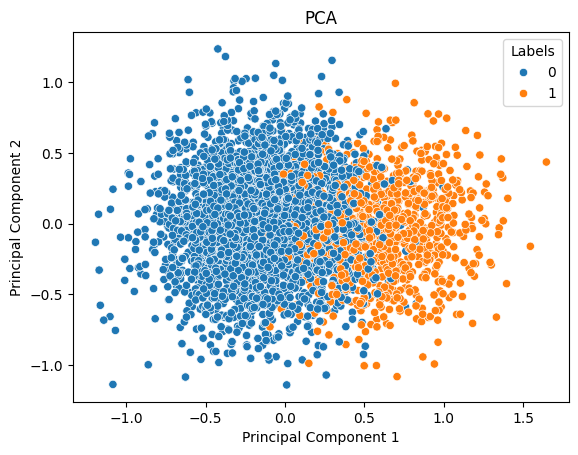

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_combined)


sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels_combined)
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Labels')
plt.show()


In [ ]:
 def convert_cluster_labels(cluster_labels, ground_truth_labels):
            unique_clusters = np.unique(cluster_labels)
            num_clusters = len(unique_clusters)
            num_classes = len(np.unique(ground_truth_labels))

            # Create a mapping between cluster labels and ground truth labels
            label_mapping = {}
            for cluster_label in unique_clusters:
                mask = (cluster_labels == cluster_label)
                assigned_labels = ground_truth_labels[mask]
                # print(assigned_labels)
                unique_assigned_labels, counts = np.unique(assigned_labels, return_counts=True)
                # print(unique_assigned_labels)
                # print(counts)
                mapped_label = unique_assigned_labels[np.argmax(counts)]
                label_mapping[cluster_label] = mapped_label

            # Convert cluster labels to ground truth labels
            converted_labels = np.zeros_like(cluster_labels)
            for cluster_label, mapped_label in label_mapping.items():
                converted_labels[cluster_labels == cluster_label] = mapped_label

            return converted_labels

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report


n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(df_train)
cluster_labels = kmeans.predict(df_test)

print(classification_report(test_labels, cluster_labels))



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1095
           1       0.53      0.92      0.67       305

    accuracy                           0.81      1400
   macro avg       0.75      0.85      0.77      1400
weighted avg       0.88      0.81      0.82      1400



In [ ]:
np.unique(cluster_labels,return_counts=True)

(array([0, 1], dtype=int32), array([872, 528]))

In [ ]:
new_labels=convert_cluster_labels(cluster_labels,test_labels)

In [ ]:
np.unique(new_labels,return_counts=True)

(array([0, 1], dtype=int32), array([872, 528]))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report


n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(df_train)
cluster_labels = kmeans.predict(df_test)

print(classification_report(test_labels, new_labels))



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1095
           1       0.53      0.92      0.67       305

    accuracy                           0.81      1400
   macro avg       0.75      0.85      0.77      1400
weighted avg       0.88      0.81      0.82      1400



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from keras.optimizers import Adam

model = Sequential([
    Dense(64, activation='relu', input_shape=(256,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
# Define callbacks




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [ ]:
df_train.shape

(3787, 256)

In [ ]:
train_labels.shape

(3787,)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(df_train,
train_labels,
                    epochs=200,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/200
95/95 [==============================] - 4s 8ms/step - loss: 0.5807 - accuracy: 0.7181 - val_loss: 0.5581 - val_accuracy: 0.8100
Epoch 2/200
95/95 [==============================] - 0s 4ms/step - loss: 0.4047 - accuracy: 0.8194 - val_loss: 1.5589 - val_accuracy: 0.8100
Epoch 3/200
95/95 [==============================] - 0s 4ms/step - loss: 0.2982 - accuracy: 0.8521 - val_loss: 2.1083 - val_accuracy: 0.8100
Epoch 4/200
95/95 [==============================] - 0s 4ms/step - loss: 0.2305 - accuracy: 0.9082 - val_loss: 1.8352 - val_accuracy: 0.8100
Epoch 5/200
95/95 [==============================] - 0s 4ms/step - loss: 0.1918 - accuracy: 0.9231 - val_loss: 1.3825 - val_accuracy: 0.8140
Epoch 6/200
95/95 [==============================] - 0s 4ms/step - loss: 0.2027 - accuracy: 0.9145 - val_loss: 0.7561 - val_accuracy: 0.8311
Epoch 7/200
95/95 [==============================] - 0s 4ms/step - loss: 0.1691 - accuracy: 0.9323 - val_loss: 0.5635 - val_accuracy: 0.8575
Epoch 8/200
9

In [ ]:
test_loss, test_acc = model.evaluate(df_test,test_labels)

print('Test accuracy:', test_acc)

44/44 [==============================] - 0s 3ms/step - loss: 0.2561 - accuracy: 0.9379
Test accuracy: 0.9378571510314941
